In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [2]:
embeddings = pd.read_csv("./data/embeddings.csv")
feat_importance = pd.read_csv("./data/feat_importance.csv")

In [3]:
embeddings.head(2)

,graph_id,graph_label,basic_expansion,self_walk,page_rank,degree_centrality,closeness_centrality,load_centrality,eigenvector_centrality,lsme,dataset,feat_len
0,0,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.070985,BZR,1
1,1,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,0.012324,BZR,1


In [4]:
feat_importance.head(2)

,features,importance,dataset
0,basic_expansion_1,0.029374,NCI1
1,self_walk_1,0.027310,NCI1


In [5]:
datasets = ["BZR", "NCI1", "MUTAG", "PROTEINS", "IMDB"]
fixed_cols = ["graph_id", "graph_label", "dataset", "feat_len"]

In [7]:

emb_data = pd.DataFrame()
for dataset in datasets:
    df = embeddings[embeddings["dataset"] == dataset].copy(deep=True)
    dfm = pd.DataFrame()
    for feat_len in df["feat_len"].unique().tolist():
        tmp = df[df["feat_len"] == feat_len].copy(deep=True)
        col_rename = {}
        for col in tmp.columns:
            if col not in fixed_cols:
                col_rename[col] = col +"_"+ str(feat_len)
        tmp.rename(columns=col_rename, inplace=True)
        tmp = tmp.drop('feat_len', axis=1)
        tmp = tmp.drop('dataset', axis=1)
        if dfm.empty:
            dfm = tmp.copy(deep=True)
        else:
            dfm = dfm.merge(tmp, on=["graph_id", "graph_label"])
    dfm["dataset"] = dataset        
    if emb_data.empty:
        emb_data = dfm.copy(deep=True)
    else:
        emb_data = pd.concat([emb_data, dfm])

In [8]:
emb_data.head(2)

,graph_id,graph_label,basic_expansion_1,self_walk_1,page_rank_1,degree_centrality_1,closeness_centrality_1,load_centrality_1,eigenvector_centrality_1,lsme_1,...,lsme_3,basic_expansion_4,self_walk_4,page_rank_4,degree_centrality_4,closeness_centrality_4,load_centrality_4,eigenvector_centrality_4,lsme_4,dataset
0,0,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.070985,...,-0.009453,-0.210577,-0.203792,0.308946,0.291383,-0.376381,-0.196976,-0.286197,-0.149529,BZR
1,1,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,0.012324,...,-0.098743,0.004913,-0.210504,0.228915,0.200574,-0.279066,-0.166603,-0.232289,0.101702,BZR


In [9]:
emb_data.to_csv("./data/embeddings_flat.csv", index=False)

# Build Models - Individual Features

In [8]:
def build_models_Individual_Features(data, dataset, feat_imp):

    feat_imp_df = feat_imp[feat_imp["dataset"] == dataset].copy(deep=True)
    data_df = data[data["dataset"] == dataset].copy(deep=True)

    raw_classes = data_df["graph_label"].unique().tolist()
    class_map = {}
    class_remap = 0
    for class_val in raw_classes:
        class_map[class_val] = class_remap
        class_remap += 1
    data_df["graph_label"] = data_df["graph_label"].apply(lambda x: class_map[x])
    
    feat_imp_df = pd.DataFrame(feat_imp_df.groupby(by=["features"])["importance"].mean()).reset_index()
    feat_imp_df.sort_values(by=["importance"], ascending=False, inplace=True)
    feat_imp_list = feat_imp_df["features"].tolist()

    feat_list = []
    accuracy_list = []
    for feat in tqdm(feat_imp_list):
        for i in range(30):
            selected_feat = [feat]
    
            X = data_df[selected_feat].copy(deep=True)
            y = data_df[["graph_label"]].copy(deep=True)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
    
            # Random Forrest
            model = RandomForestClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).flatten()
            accuracy = accuracy_score(y_test, y_pred)
    
            feat_list.append(feat)
            accuracy_list.append(accuracy)
            
    results = pd.DataFrame()
    results["selected_features"] = feat_list
    results["acccuracy"] = accuracy_list
    return results

In [9]:
df = build_models_Individual_Features(emb_data, "NCI1", feat_importance)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:52<00:00,  5.41s/it]


In [18]:
df["color"] = "blue"
df.loc[df['selected_features'] == "page_rank_1", "color"] = "green"

In [23]:
df[df["selected_features"] == "page_rank_1"]

,selected_features,acccuracy,color
870,page_rank_1,0.608273,green
871,page_rank_1,0.598540,green
872,page_rank_1,0.620438,green
873,page_rank_1,0.616383,green
874,page_rank_1,0.603406,green
875,page_rank_1,0.593674,green
876,page_rank_1,0.609084,green
877,page_rank_1,0.623682,green
878,page_rank_1,0.643147,green
879,page_rank_1,0.606650,green


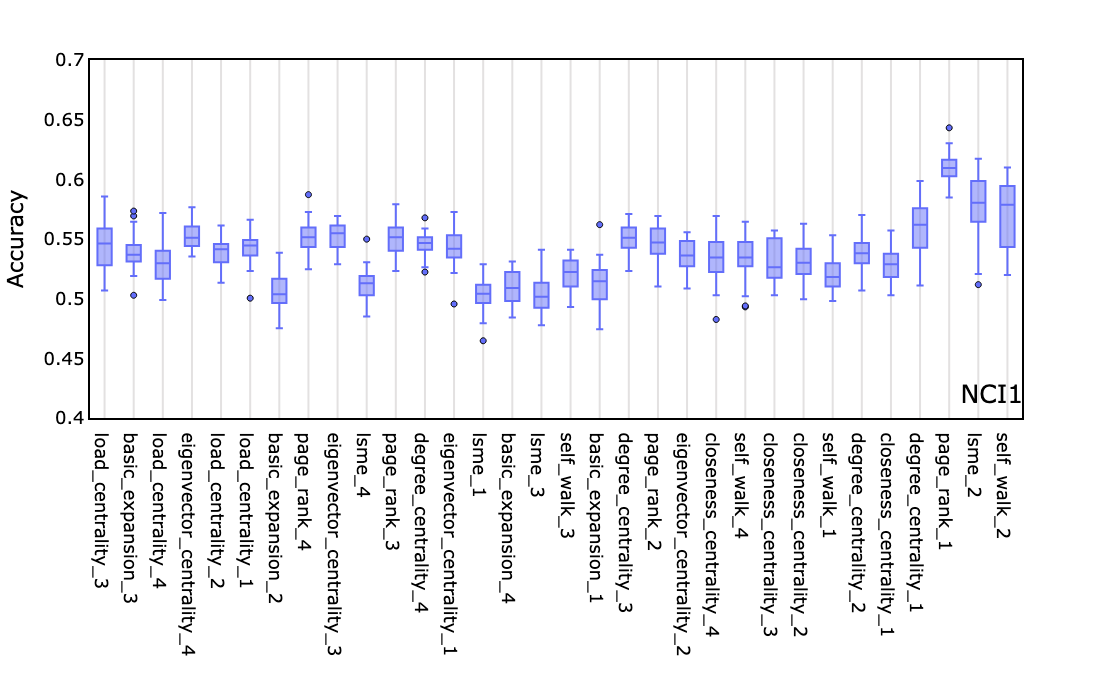

In [35]:
fig = px.box(df, x="selected_features", y="acccuracy")

fig.update_layout(paper_bgcolor='white')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(color='black')
fig.update_layout(
    yaxis = dict(
        title = "Accuracy",
        zeroline=True,
        showline = True,
        linecolor = 'black',
        mirror=True,
        linewidth = 2
    ),
    xaxis = dict(
        title = "",
        mirror=True,
        zeroline=True,
        showline = True,
        linecolor = 'black',
        linewidth = 2,
    ),
    width=1150,
    height=700,
    font=dict(
    size=18,
    color="black")  
)
fig.update_layout(title={'text':'NCI1', 'y':0.45, 'x':0.9,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(showlegend=False)
fig.update_layout(yaxis_range=[0.4,0.7])
fig.update_xaxes(showgrid=True, gridwidth=2.0, gridcolor='#e3e1e1')
fig.update_yaxes(showgrid=False, gridwidth=0.5, gridcolor='grey')
fig.update_traces(marker_line_color='black', marker_line_width=1.0, opacity=1.0)


fig.show()

# Build Models - Additive Features

In [49]:
def build_models(data, dataset, feat_imp):

    feat_imp_df = feat_imp[feat_imp["dataset"] == dataset].copy(deep=True)
    data_df = data[data["dataset"] == dataset].copy(deep=True)

    raw_classes = data_df["graph_label"].unique().tolist()
    class_map = {}
    class_remap = 0
    for class_val in raw_classes:
        class_map[class_val] = class_remap
        class_remap += 1
    data_df["graph_label"] = data_df["graph_label"].apply(lambda x: class_map[x])
    
    feat_imp_df = pd.DataFrame(feat_imp_df.groupby(by=["features"])["importance"].mean()).reset_index()
    feat_imp_df.sort_values(by=["importance"], ascending=False, inplace=True)
    feat_imp_list = feat_imp_df["features"].tolist()

    selected_feat = []
    feat_list = []
    accuracy_mean = []
    accuracy_std = []
    for feat in tqdm(feat_imp_list):
        acc = []
        for i in range(30):
            selected_feat.append(feat)
    
            X = data_df[selected_feat].copy(deep=True)
            y = data_df[["graph_label"]].copy(deep=True)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
    
            # Random Forrest
            model = RandomForestClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).flatten()
            accuracy = accuracy_score(y_test, y_pred)
    
            acc.append(accuracy)
            
        feat_list.append(feat)
        accuracy_mean.append(np.mean(np.array(acc)))
        accuracy_std.append(np.std(np.array(acc)))

    results = pd.DataFrame()
    results["selected_features"] = feat_list
    results["accuracy_contribution"] = accuracy_mean
    results["accuracy_contribution_std"] = accuracy_std
    return results


In [54]:
BZR = build_models(emb_data, "BZR", feat_importance)
IMDB = build_models(emb_data, "IMDB", feat_importance)
NCI1 = build_models(emb_data, "NCI1", feat_importance)
PROTEINS = build_models(emb_data, "PROTEINS", feat_importance)
MUTAG = build_models(emb_data, "MUTAG", feat_importance)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:52<00:00,  1.64s/it]


In [56]:
BZR.to_csv("./results/BZR.csv", index=False)
IMDB.to_csv("./results/IMDB.csv", index=False)
NCI1.to_csv("./results/NCI1.csv", index=False)
PROTEINS.to_csv("./results/PROTEINS.csv", index=False)
MUTAG.to_csv("./results/MUTAG.csv", index=False)